##Детекція транспортних засобів за допомогою YOLOv8

Огляд проєкту

Мета цього проєкту — натренувати модель детекції об’єктів на архітектурі YOLOv8 nano на датасеті для детекції транспортних засобів, експортованому у форматі YOLO.

Проєкт включає:
- Дослідження та аналіз датасету
- Тренування моделі YOLOv8n
- Оцінку за стандартними метриками детекції об’єктів
- Візуальний аналіз передбачень

Цей notebook слідує структурованому пайплайну для забезпечення відтворюваності та зрозумілості.

##Вибір датасету
Обраний датасет — це набір даних для детекції транспортних засобів, експортований з Roboflow у форматі YOLOv8.
Причини вибору:
- Датасет уже розмічений у форматі YOLO.
- Містить кілька класів об’єктів.
- Розмір датасету (2818 зображень) достатній для тренування легкої моделі.
- Анотації були попередньо оброблені та аугментовані під час експорту.

Датасет підходить для тренування YOLOv8 nano за обмежених обчислювальних ресурсів.

##Розпакування датасету

Датасет завантажено як ZIP-архів з Roboflow у форматі YOLO. Розпаковуємо архів у локальну директорію для подальшої обробки.

In [ ]:
!unzip VEHICLE.v9i.yolov8.zip -d dataset

Streaming output truncated to the last 5000 lines.
 extracting: dataset/train/images/screenshot_1697595893-1901033_jpg.rf.b92dadda69195f1052a349dd8cccb2c8.jpg  
 extracting: dataset/train/images/screenshot_1697595893-1901033_jpg.rf.fe521bccfd525a8c09c82568ad4fa1c4.jpg  
 extracting: dataset/train/images/screenshot_1697595898-407982_jpg.rf.1dd5e41dc648c80f82dcfe305305ca6a.jpg  
 extracting: dataset/train/images/screenshot_1697595898-407982_jpg.rf.26a7ba7dec2fb8b17beaf7657fef2698.jpg  
 extracting: dataset/train/images/screenshot_1697595898-407982_jpg.rf.6245233e1e544871d8246a2a934796e8.jpg  
 extracting: dataset/train/images/screenshot_1697595902-1719458_jpg.rf.6be35d7f3c69609ca16a14055afecae4.jpg  
 extracting: dataset/train/images/screenshot_1697595902-1719458_jpg.rf.76f77ad30dba5a3a56290d041693068d.jpg  
 extracting: dataset/train/images/screenshot_1697595902-1719458_jpg.rf.8d307ec2fbdb425bf189945abf311229.jpg  
 extracting: dataset/train/images/screenshot_1697595907-4730635_jpg.rf.3

##Конфігурація датасету

Датасет містить файл `data.yaml`, який визначає:

- Шляхи до тренувальної, валідаційної та тестової вибірки
- Кількість класів
- Назви класів

Перевіряємо цей файл, щоб упевнитися, що шляхи та інформація про класи правильні.

In [ ]:
!cat dataset/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 2
names: ['Bike', 'Car']

roboflow:
  workspace: marchel-maulana-fahrezi
  project: vehicle-emspn
  version: 9
  license: CC BY 4.0
  url: https://universe.roboflow.com/marchel-maulana-fahrezi/vehicle-emspn/dataset/9

##Огляд датасету

У цьому розділі аналізуємо структуру датасету:

- Кількість зображень у train, validation та test
- Кількість класів
- Загальний розмір датасету

In [ ]:
import os

train_images = len(os.listdir("dataset/train/images"))
val_images = len(os.listdir("dataset/valid/images"))
test_images = len(os.listdir("dataset/test/images"))
total_images = train_images + val_images + test_images

print(f"Train images: {train_images}")
print(f"Validation images: {val_images}")
print(f"Test images: {test_images}")
print(f"Total images: {total_images}")

Train images: 2464
Validation images: 236
Test images: 118
Total images: 2818


##Аналіз датасету

У цьому розділі ми:

- Визначаємо назви класів
- Аналізуємо розподіл класів (баланс)
- Вручну оглядаємо кілька зображень для оцінки якості розмітки

In [ ]:
import yaml

with open("dataset/data.yaml", "r") as f:
    data_config = yaml.safe_load(f)

class_names = data_config["names"]
num_classes = data_config["nc"]

print(f"Number of classes: {num_classes}")
print("Class names:", class_names)

Number of classes: 2
Class names: ['Bike', 'Car']


##Аналіз розподілу класів

Аналізуємо файли міток у тренувальній вибірці, щоб оцінити баланс класів. Кожен файл міток містить анотації bounding box у форматі YOLO.

In [ ]:
from collections import Counter

label_path = "dataset/train/labels"
class_counts = Counter()

for file in os.listdir(label_path):
    with open(os.path.join(label_path, file), "r") as f:
        lines = f.readlines()
        for line in lines:
            class_id = int(line.split()[0])
            class_counts[class_id] += 1

for class_id, count in class_counts.items():
    print(f"{class_names[class_id]}: {count} objects")

Car: 17229 objects
Bike: 24852 objects


##Ручний огляд

Було вручну переглянуто кілька зображень для оцінки відповідності bounding box об’єктам та якості розмітки.

Спостереження:

- Bounding boxes загалом добре відповідають об’єктам транспортних засобів.
- Деякі дрібні об’єкти можуть бути складнішими для детекції через роздільну здатність.
- Дисбаланс класів може вплинути на результати тренування.

Загалом якість розмітки виглядає стабільною та придатною для тренування.

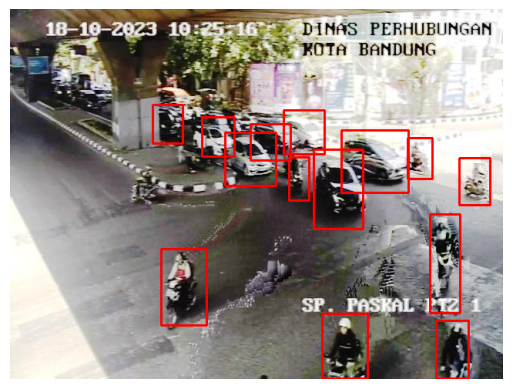

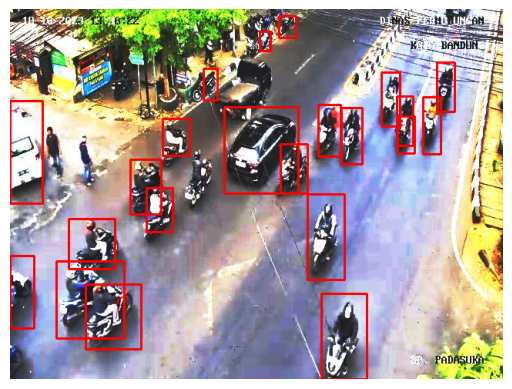

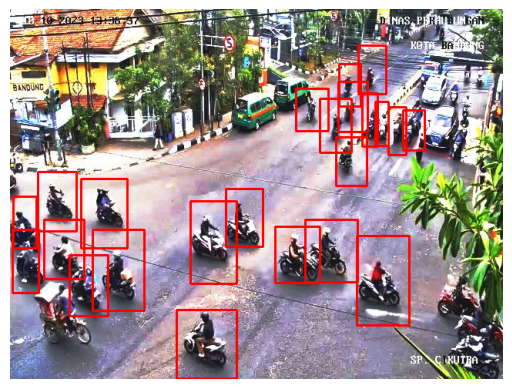

In [ ]:
import cv2
import matplotlib.pyplot as plt
import random

image_dir = "dataset/train/images"
label_dir = "dataset/train/labels"

sample_images = random.sample(os.listdir(image_dir), 3)

for img_name in sample_images:
    img_path = os.path.join(image_dir, img_name)
    label_path = os.path.join(label_dir, img_name.replace(".jpg", ".txt"))

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    h, w, _ = image.shape

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f.readlines():
                class_id, x_center, y_center, width, height = map(float, line.split())

                x1 = int((x_center - width/2) * w)
                y1 = int((y_center - height/2) * h)
                x2 = int((x_center + width/2) * w)
                y2 = int((y_center + height/2) * h)

                cv2.rectangle(image, (x1, y1), (x2, y2), (255,0,0), 2)

    plt.imshow(image)
    plt.axis("off")
    plt.show()

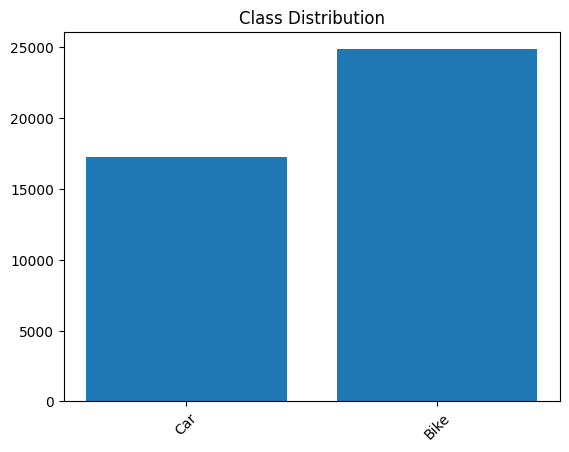

In [ ]:
import matplotlib.pyplot as plt

plt.bar([class_names[i] for i in class_counts.keys()],
        class_counts.values())

plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.show()

##Встановлення залежностей

Встановлюємо бібліотеку `ultralytics`, яка надає реалізацію YOLOv8 для тренування та оцінки.

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.4 MB/s eta 0:00:00


##Тренування моделі

Використовуємо модель YOLOv8 nano завдяки її легкій архітектурі та придатності для менших датасетів.

Кількість епох: 30

Обґрунтування:

- Розмір датасету помірний (2818 зображень).
- YOLOv8n сходиться відносно швидко.
- 30 епох дозволяють спостерігати тенденції метрик без сильного overfitting.
- За потреби можна продовжити тренування, якщо метрики на валідації продовжують покращуватися.

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

model.train(
    data="dataset/data.yaml",
    epochs=30,
    imgsz=640
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.4.16 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, io

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79c3d59be630>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

##Оцінка моделі

Після тренування оцінюємо модель за стандартними метриками детекції об’єктів:

- **Precision** — частка правильних позитивних детекцій.
- **Recall** — частка реальних об’єктів, які були правильно виявлені.
- **mAP50** — середня точність при порозі IoU 0.5.

Ці метрики допомагають оцінити точність детекції та якість локалізації.

In [ ]:
metrics = model.val()

print(metrics)

Ultralytics 8.4.16 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
Model summary (fused): 73 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1801.5±567.7 MB/s, size: 80.3 KB)
val: Scanning /content/dataset/valid/labels.cache... 236 images, 3 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 236/236 76.1Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 15/15 3.2it/s 4.7s
                   all        236       4268      0.816      0.789      0.835      0.459
                  Bike        217       2580      0.766      0.722      0.771      0.349
                   Car        220       1688      0.866      0.857        0.9      0.568
Speed: 2.4ms preprocess, 4.7ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to /content/runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultral

### Оцінка результатів

Після 30 епох на validation наборі отримано такі метрики:

- **Precision**: 0.816 — з усіх передбачених об'єктів 81.6% правильні.
- **Recall**: 0.789 — модель виявила 78.9% усіх реальних об'єктів.
- **mAP@50**: 0.835 — висока середня точність при IoU=0.5.
- **mAP@50:95**: 0.459 — строга метрика, показує, що локалізація не ідеальна, але прийнятна.

Метрики швидко росли в перші 10–15 епох (loss падав, mAP зростав), потім покращення сповільнилося — тому 30 епох — оптимально, overfitting мінімальний.

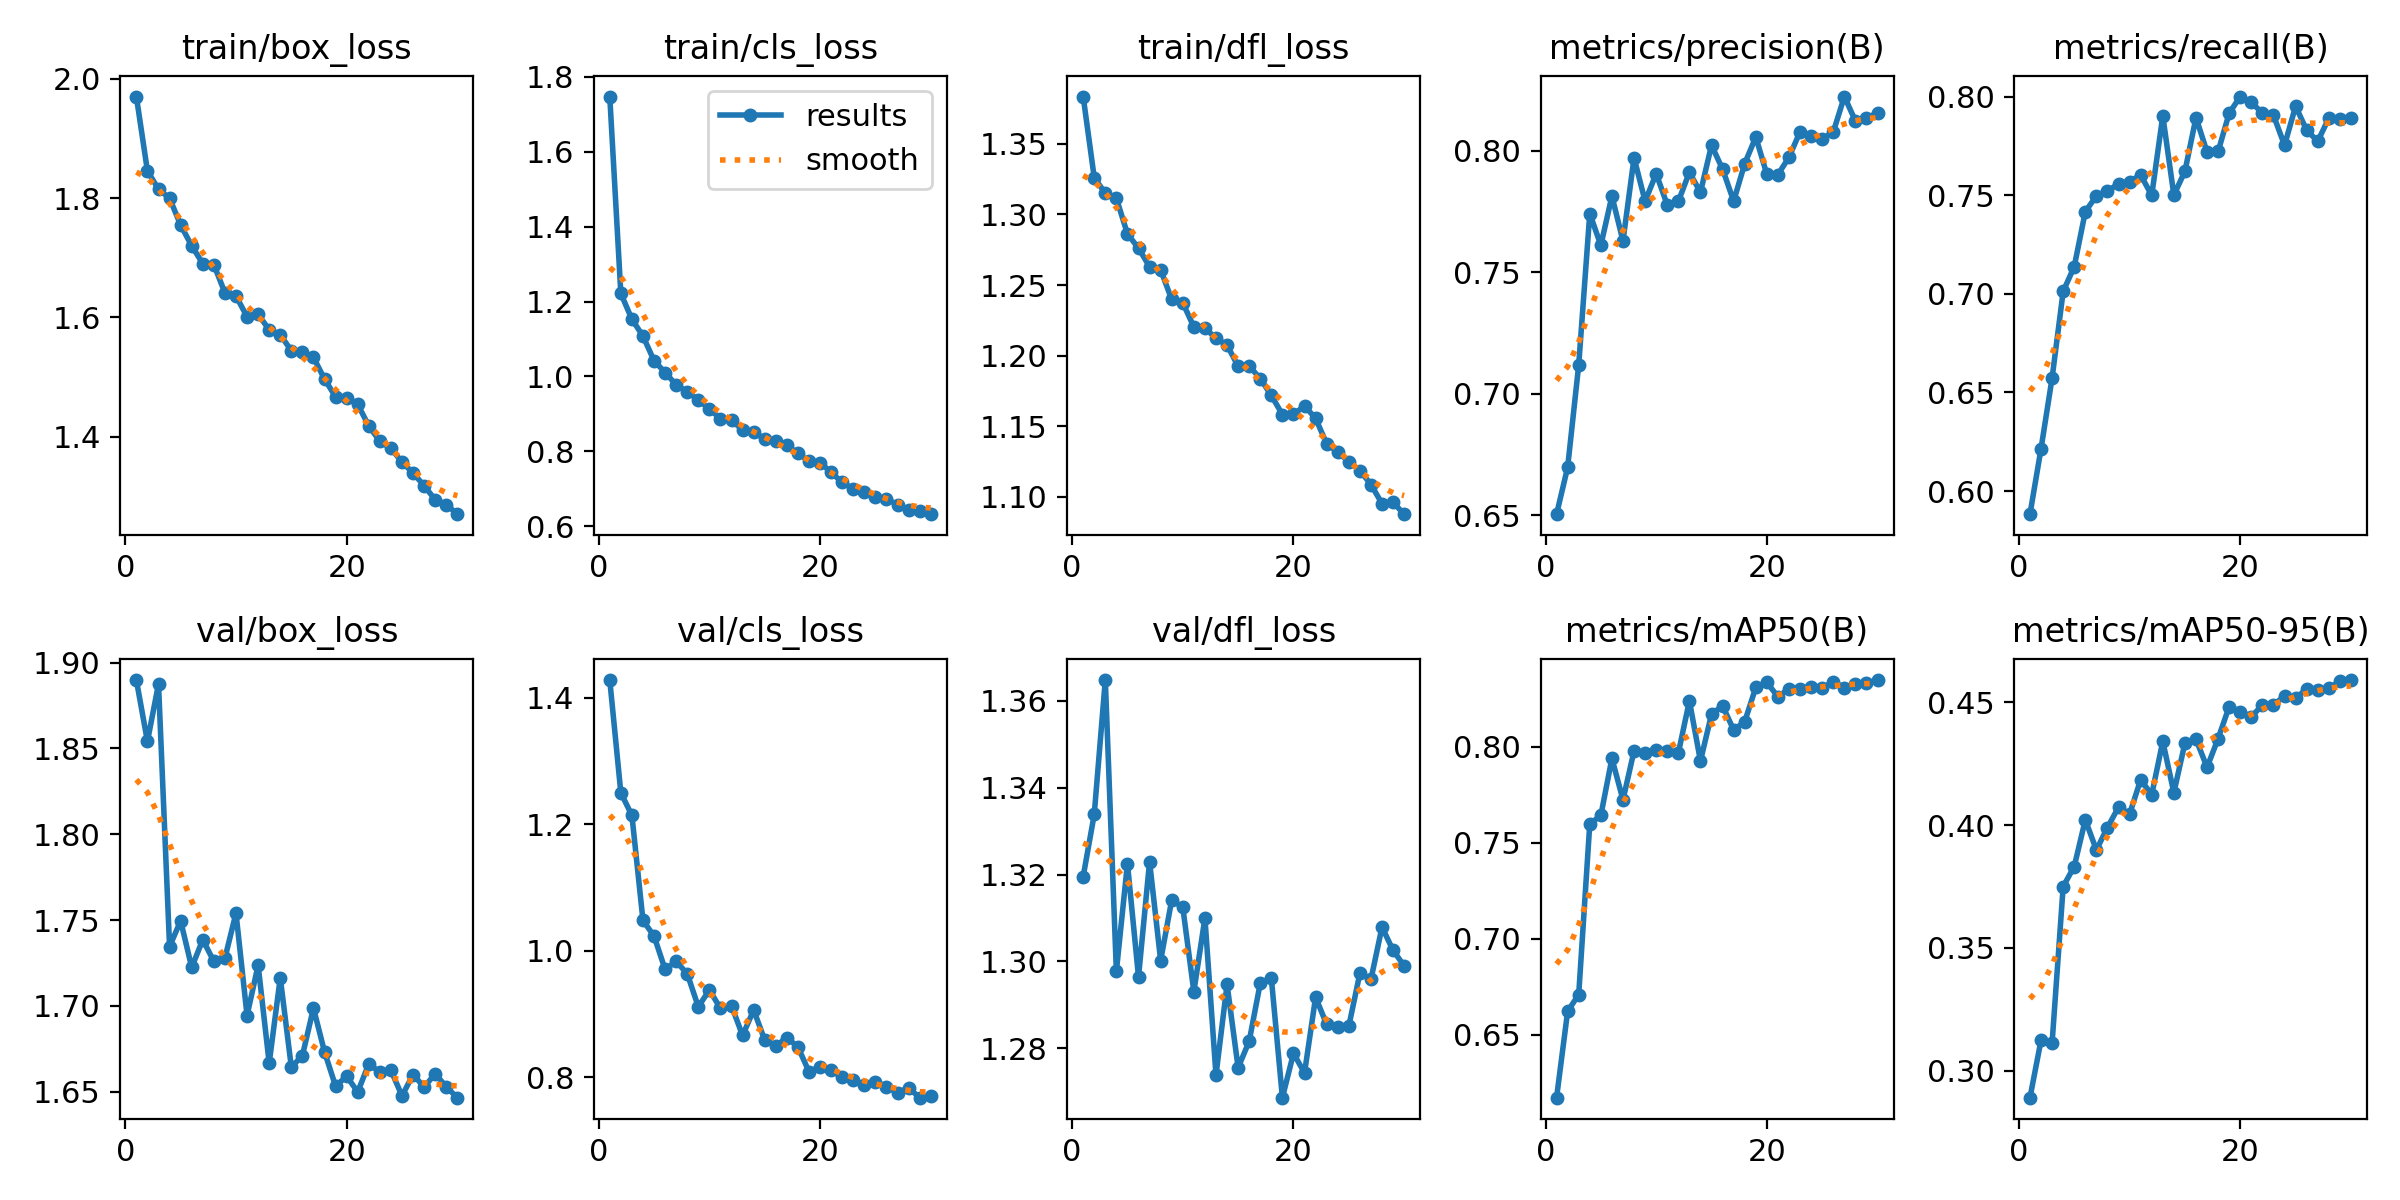

In [ ]:
from IPython.display import Image, display

display(Image(filename='/content/runs/detect/train/results.png', width=900))


image 1/1 /content/dataset/valid/images/screenshot_1697600758-5373752_jpg.rf.1aa18abba375cfaafb0b94bb5c3a272b.jpg: 480x640 1 Bike, 5 Cars, 43.2ms
Speed: 2.3ms preprocess, 43.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /content/runs/detect/predict
Збережено: /content/runs/detect/predict/screenshot_1697600758-5373752_jpg.rf.1aa18abba375cfaafb0b94bb5c3a272b.jpg


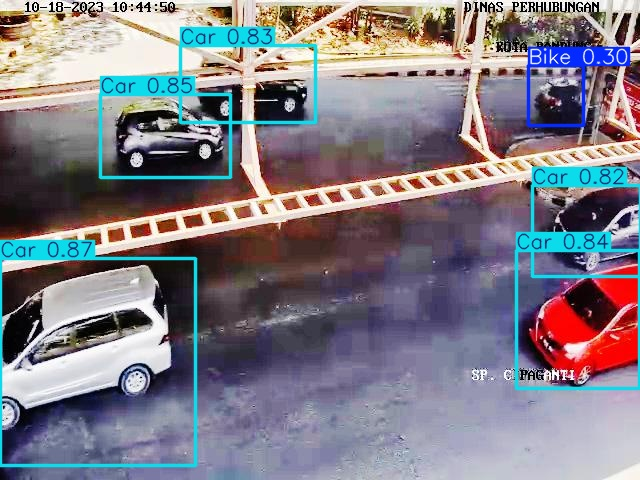


image 1/1 /content/dataset/valid/images/screenshot_1697681708-9255626_jpg.rf.564f72f1f4476c211824d2ad9e86a754.jpg: 480x640 32 Bikes, 3 Cars, 7.7ms
Speed: 2.1ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /content/runs/detect/predict
Збережено: /content/runs/detect/predict/screenshot_1697681708-9255626_jpg.rf.564f72f1f4476c211824d2ad9e86a754.jpg


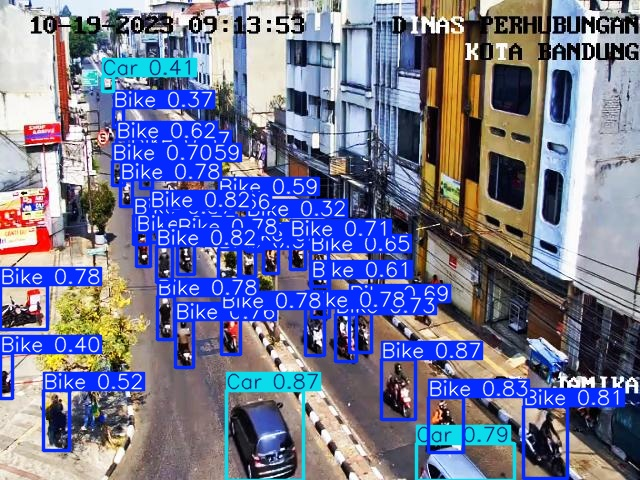


image 1/1 /content/dataset/valid/images/frame_3496_jpg.rf.0812bab08eb0fa6898f036d653ee67a0.jpg: 480x640 3 Bikes, 4 Cars, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /content/runs/detect/predict
Збережено: /content/runs/detect/predict/frame_3496_jpg.rf.0812bab08eb0fa6898f036d653ee67a0.jpg


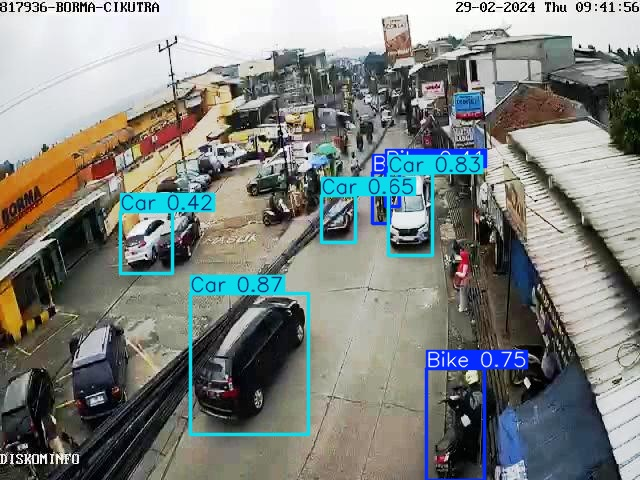


image 1/1 /content/dataset/valid/images/screenshot_1697612149-9201202_jpg.rf.6ecebd45184463f29e8cd7a59efeb995.jpg: 480x640 7 Bikes, 1 Car, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /content/runs/detect/predict
Збережено: /content/runs/detect/predict/screenshot_1697612149-9201202_jpg.rf.6ecebd45184463f29e8cd7a59efeb995.jpg


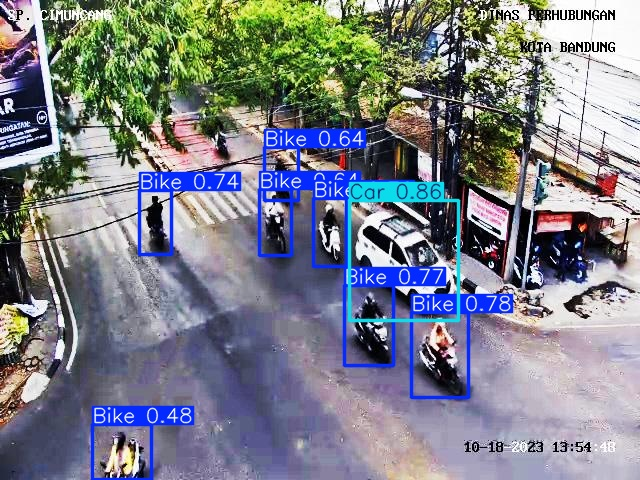


image 1/1 /content/dataset/valid/images/frame_775_jpg.rf.944d61cd5367228ba5c8c6dbdfe91d21.jpg: 480x640 12 Bikes, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /content/runs/detect/predict
Збережено: /content/runs/detect/predict/frame_775_jpg.rf.944d61cd5367228ba5c8c6dbdfe91d21.jpg


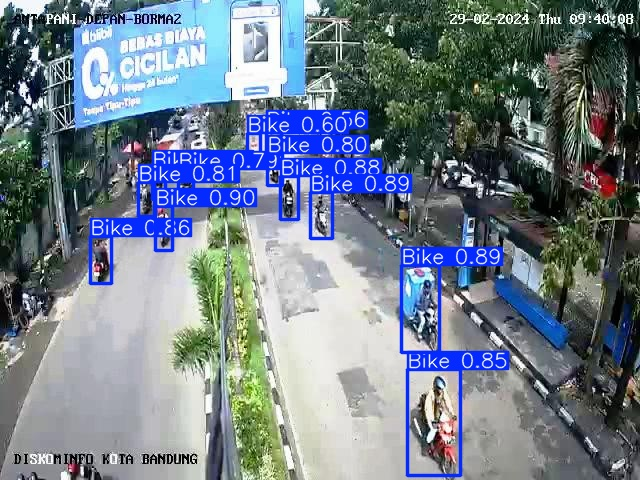


image 1/1 /content/dataset/valid/images/screenshot_1697611033-3993516_jpg.rf.f36fde60ca09feb6ae17897c0ffe386d.jpg: 480x640 6 Bikes, 2 Cars, 14.2ms
Speed: 1.7ms preprocess, 14.2ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /content/runs/detect/predict
Збережено: /content/runs/detect/predict/screenshot_1697611033-3993516_jpg.rf.f36fde60ca09feb6ae17897c0ffe386d.jpg


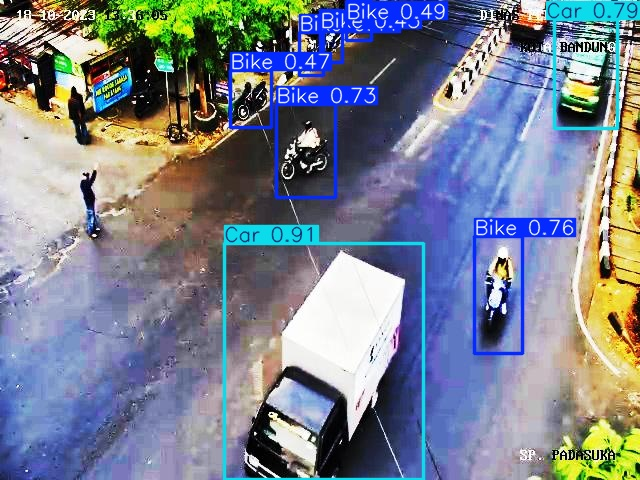


image 1/1 /content/dataset/valid/images/frame_1179_jpg.rf.0d35bdeb8e3364ecf3a62abc487ae94d.jpg: 480x640 4 Bikes, 3 Cars, 15.3ms
Speed: 3.3ms preprocess, 15.3ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /content/runs/detect/predict
Збережено: /content/runs/detect/predict/frame_1179_jpg.rf.0d35bdeb8e3364ecf3a62abc487ae94d.jpg


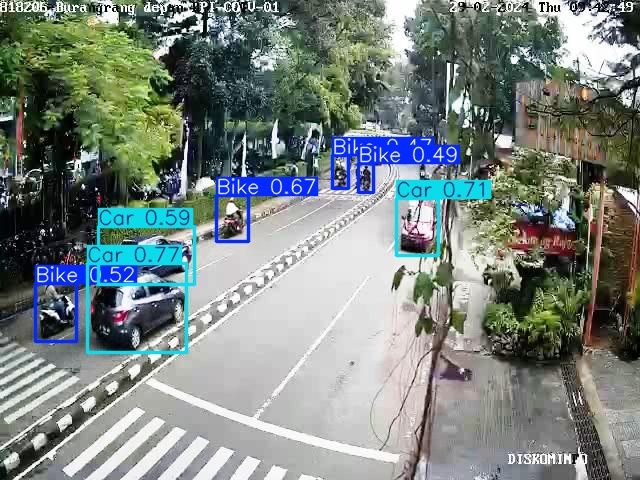


image 1/1 /content/dataset/valid/images/screenshot_1697611009-6724672_jpg.rf.2470ce61322d622a54cb479347e58884.jpg: 480x640 11 Bikes, 11 Cars, 8.2ms
Speed: 1.9ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /content/runs/detect/predict
Збережено: /content/runs/detect/predict/screenshot_1697611009-6724672_jpg.rf.2470ce61322d622a54cb479347e58884.jpg


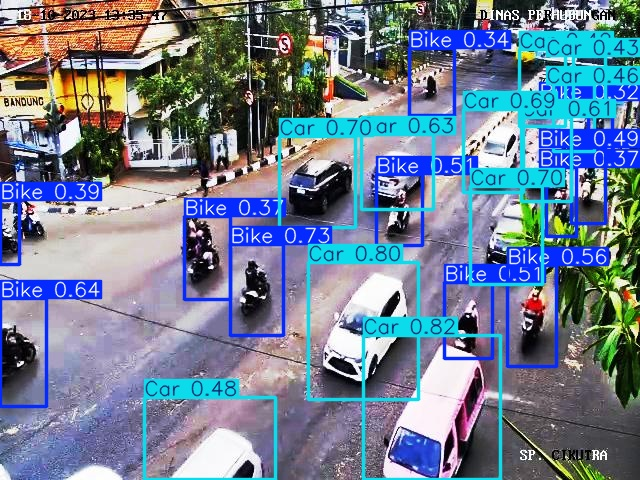

In [ ]:
import glob
import random
import os
from IPython.display import Image, display

val_images = glob.glob("dataset/valid/images/*.jpg")
sample_images = random.sample(val_images, 8)

predict_dir = "predictions_examples"
os.makedirs(predict_dir, exist_ok=True)

for img_path in sample_images:
    results = model.predict(img_path, save=True, conf=0.3, iou=0.5)
    saved_path = results[0].save_dir + "/" + os.path.basename(img_path)
    print(f"Збережено: {saved_path}")
    display(Image(filename=saved_path, width=600))

Вдалі приклади: модель точно детектує великі Car та Bike на передньому плані.
Невдалі: пропускає маленькі/далекі Bike, або коли об'єкт частково закритий.

### Висновки

Обрав цей датасет, бо:
- Він компактний (2818 зображень), вже в форматі YOLOv8.
- Має лише 2 класи (Bike, Car) — просто аналізувати.
- Практична задача (детекція транспорту).

Що вийшло добре:
- mAP@50 = 0.835 після 30 епох — гарний результат для yolov8n.
- Висока precision — модель рідко "вигадує" об'єкти.
- Добре справляється з чіткими, великими об'єктами.

Де модель помиляється:
- Пропускає ~20% об'єктів (низький recall на дрібних/далеко розміщених об'єктах).
- Через дисбаланс (Bike більше) і легку архітектуру nano — слабше на маленьких об'єктах.
- Локалізація неідеальна (mAP@50:95 = 0.46) — бокси трохи неточні.

Що б змінив з більше часом:
- Тренував би 50–80 епох + early stopping.
- Спробував yolov8s або yolov8m для кращої точності.
- Посилив augmentation (особливо для дрібних об'єктів: mosaic, scale, blur).